<a href="https://colab.research.google.com/github/zhirnovv/intelligent_systems/blob/master/g_crypto_research_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initialization

In [3]:
#@title Import modules

import pandas as pd
import numpy as np
from datetime import datetime
import plotly.graph_objects as go
from google.colab import drive
import matplotlib.pyplot as plt
import gc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [4]:
#@title Check garbage collector
gc.isenabled()

True

In [5]:
#@title Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#@title Configure raw data path and verify correctness

RAW_DATA_PATH = '/content/drive/MyDrive/uni/y4/intelligent-systems/g-crypto-research-competition/data/raw/'
!ls $RAW_DATA_PATH

asset_details.csv	       example_test.csv        train.csv
example_sample_submission.csv  supplemental_train.csv


#Loading data

In [7]:
#@title Load and verify the training/validation dataset
crypto_df = pd.read_csv(RAW_DATA_PATH + 'train.csv')
crypto_df.head(10)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.580000,2399.5000,2357.1400,2374.590000,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.530000,8.5300,8.5300,8.530000,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.194000,14013.8000,13666.1100,13850.176000,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.659600,7.6596,7.6567,7.657600,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.920000,25.9200,25.8740,25.877000,121.087310,25.891363,-0.008264
5,1514764860,6,173.0,738.302500,746.0000,732.5100,738.507500,335.987856,738.839291,-0.004809
6,1514764860,9,167.0,225.330000,227.7800,222.9800,225.206667,411.896642,225.197944,-0.009791
7,1514764860,11,7.0,329.090000,329.8800,329.0900,329.460000,6.635710,329.454118,NaN
8,1514764920,2,53.0,2374.553333,2400.9000,2354.2000,2372.286667,24.050259,2371.434498,-0.004079
9,1514764920,0,7.0,8.530000,8.5300,8.5145,8.514500,71.390000,8.520215,-0.015875


In [8]:
#@title Load and verify the test dataset
crypto_test_df = pd.read_csv(RAW_DATA_PATH + 'supplemental_train.csv')
crypto_test_df.head(10)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1623542400,3,1201.0,1.478556,1.48603,1.47800,1.483681,654799.561103,1.481439,-0.002594
1,1623542400,2,1020.0,580.306667,583.89000,579.91000,582.276667,1227.988328,581.697038,-0.009143
2,1623542400,0,626.0,343.789500,345.10800,343.64000,344.598000,1718.832569,344.441729,-0.004525
3,1623542400,1,2888.0,35554.289632,35652.46465,35502.67000,35602.004286,163.811537,35583.469303,0.003096
4,1623542400,4,433.0,0.312167,0.31260,0.31192,0.312208,585577.410442,0.312154,0.001426
5,1623542400,5,359.0,4.832550,4.84590,4.82290,4.837583,47143.548386,4.836607,-0.000579
6,1623542400,7,541.0,55.223080,55.49400,55.18200,55.344680,6625.201803,55.298816,-0.003998
7,1623542400,6,2186.0,2371.194286,2379.20000,2369.67000,2374.380714,1214.128692,2374.335307,0.002565
8,1623542400,8,35.0,1.003150,1.01980,0.98730,1.003300,7061.927600,1.002936,-0.005097
9,1623542400,9,560.0,161.933429,162.48000,161.73000,162.214714,1485.009496,162.231310,0.000686


In [9]:
#@title Load and verify asset details
asset_details_df = pd.read_csv(RAW_DATA_PATH + 'asset_details.csv')
asset_details_df

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


#Data preprocessing and inspection

In [141]:
#@title Merge training dataset with asset details for easier access

crypto_df_with_asset_names = pd.merge_ordered(crypto_df, asset_details_df, fill_method="ffill", left_by="Asset_ID")
crypto_df_with_asset_names.head(10)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Weight,Asset_Name
0,1514764860,2,40.0,2376.580000,2399.5,2357.14,2374.590000,19.233005,2373.116392,-0.004218,2.397895,Bitcoin Cash
1,1514764920,2,53.0,2374.553333,2400.9,2354.20,2372.286667,24.050259,2371.434498,-0.004079,2.397895,Bitcoin Cash
2,1514764980,2,61.0,2371.633333,2401.9,2353.70,2372.063333,42.676438,2375.442755,-0.002892,2.397895,Bitcoin Cash
3,1514765040,2,95.0,2376.060000,2406.4,2344.00,2370.566667,37.820918,2371.096152,-0.003718,2.397895,Bitcoin Cash
4,1514765100,2,33.0,2372.656667,2404.6,2343.40,2370.173333,8.519679,2370.345730,-0.002171,2.397895,Bitcoin Cash
5,1514765160,2,44.0,2368.806667,2400.1,2344.00,2367.486667,27.459795,2367.328281,-0.009202,2.397895,Bitcoin Cash
6,1514765220,2,29.0,2367.920000,2399.8,2343.00,2366.860000,57.679405,2366.808135,-0.004458,2.397895,Bitcoin Cash
7,1514765280,2,69.0,2366.680000,2399.5,2343.00,2366.710000,42.115560,2367.779212,-0.006110,2.397895,Bitcoin Cash
8,1514765340,2,30.0,2365.513333,2399.4,2343.80,2366.476667,21.652614,2364.779586,-0.004424,2.397895,Bitcoin Cash
9,1514765400,2,102.0,2367.343333,2399.4,2342.00,2356.300000,36.268655,2362.093324,-0.001696,2.397895,Bitcoin Cash


In [142]:
#@title Split training dataset by Asset_ID and reindex every dataset by timestamp

split_asset_dfs = [y for x, y in crypto_df_with_asset_names.groupby('Asset_ID', as_index=False)]

for i in range(0, len(split_asset_dfs)):
  split_asset_dfs[i] = split_asset_dfs[i].set_index('timestamp')

del crypto_df_with_asset_names
gc.collect()

print('Grouped datasets by Asset_ID and reindexed by timestamp')

Grouped datasets by Asset_ID and reindexed by timestamp


In [143]:
#@title Define functions for data inspection

def all_time_gaps(dfs):
  time_gaps = []

  for df in dfs:
    dict = (df.index[1:] - df.index[:-1]).value_counts().head()
    dict['Asset_Name'] = df['Asset_Name'].unique()[0]
    time_gaps.append(dict)
  
  return pd.DataFrame(time_gaps).set_index('Asset_Name')

def all_missing_cell_counts(dfs):
  cell_counts = []
  
  for df in dfs:
    dict = df.isna().sum()
    dict['Name'] = df['Asset_Name'].unique()[0]
    cell_counts.append(dict)
  
  return pd.DataFrame(cell_counts).set_index('Name')

def all_start_dates(dfs):
  all_start_dates = []
  
  for df in dfs:
    dict = {}
    dict.update({ 
        'name': df["Asset_Name"].unique()[0], 
        'start': pd.to_datetime(df.index[0], unit='s'), 
        'end': pd.to_datetime(df.index[-1], unit='s')
        })
    all_start_dates.append(dict)
  
  return pd.DataFrame(all_start_dates).sort_values(by='start')

def all_vwap(dfs):
  for df in dfs:
    print(df["VWAP"].isna())



## Time gaps

In [144]:
#@title Inspect time gaps

all_time_gaps(split_asset_dfs)

,60,120,180,240,300,420,540
Asset_Name,,,,,,,
Binance Coin,1936018,5774,510,117.0,50.0,NaN,NaN
Bitcoin,1956136,78,12,11.0,NaN,9.0,NaN
Bitcoin Cash,1951034,2176,196,45.0,29.0,NaN,NaN
Cardano,1782506,7848,1090,270.0,79.0,NaN,NaN
Dogecoin,1080213,51442,13708,5575.0,2627.0,NaN,NaN
EOS.IO,1953951,1005,108,36.0,10.0,NaN,NaN
Ethereum,1956043,100,23,NaN,5.0,NaN,4.0
Ethereum Classic,1946419,4229,319,75.0,27.0,NaN,NaN
IOTA,1484329,70201,21250,8405.0,3815.0,NaN,NaN


In [145]:
#@title Pad time gaps

for i in range(0, len(split_asset_dfs)):
  split_asset_dfs[i] = split_asset_dfs[i].reindex(range(split_asset_dfs[i].index[0], split_asset_dfs[i].index[-1]+60, 60), method='pad')

In [146]:
#@title Inspect time gaps

all_time_gaps(split_asset_dfs)

,60
Asset_Name,
Binance Coin,1956959
Bitcoin,1956959
Bitcoin Cash,1956959
Cardano,1803769
Dogecoin,1285046
EOS.IO,1956959
Ethereum,1956959
Ethereum Classic,1956959
IOTA,1772153


## Missing data

In [147]:
#@title Inspect missing cell counts

all_missing_cell_counts(split_asset_dfs)

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Weight,Asset_Name
Name,,,,,,,,,,,
Binance Coin,0,0,0,0,0,0,0,0,27712,0,0
Bitcoin,0,0,0,0,0,0,0,0,937,0,0
Bitcoin Cash,0,0,0,0,0,0,0,0,8240,0,0
Cardano,0,0,0,0,0,0,0,0,30593,0,0
Dogecoin,0,0,0,0,0,0,0,0,273132,0,0
EOS.IO,0,0,0,0,0,0,0,0,4078,0,0
Ethereum,0,0,0,0,0,0,0,0,1056,0,0
Ethereum Classic,0,0,0,0,0,0,0,0,15115,0,0
IOTA,0,0,0,0,0,0,0,0,373158,0,0


In [154]:
#@title Set missing Target values as 0

for i in range(0, len(split_asset_dfs)):
  split_asset_dfs[i]['Target'] = split_asset_dfs[i]["Target"].fillna(method = 'pad').fillna(method = 'bfill')

In [155]:
#@title Make VWAP finite

maker = split_asset_dfs[10]

VWAP_max = np.max(maker[np.isfinite(maker['VWAP'])])['VWAP']
VWAP_min = np.min(maker[np.isfinite(maker['VWAP'])])['VWAP']

split_asset_dfs[10]['VWAP'] = np.nan_to_num(split_asset_dfs[10]['VWAP'], posinf=VWAP_max, neginf=VWAP_min)

In [156]:
#@title Inspect missing cell counts

all_missing_cell_counts(split_asset_dfs)

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Weight,Asset_Name
Name,,,,,,,,,,,
Binance Coin,0,0,0,0,0,0,0,0,0,0,0
Bitcoin,0,0,0,0,0,0,0,0,0,0,0
Bitcoin Cash,0,0,0,0,0,0,0,0,0,0,0
Cardano,0,0,0,0,0,0,0,0,0,0,0
Dogecoin,0,0,0,0,0,0,0,0,0,0,0
EOS.IO,0,0,0,0,0,0,0,0,0,0,0
Ethereum,0,0,0,0,0,0,0,0,0,0,0
Ethereum Classic,0,0,0,0,0,0,0,0,0,0,0
IOTA,0,0,0,0,0,0,0,0,0,0,0


## Drop unneeded data

In [157]:
#@title Drop unneeded data

for i in range(0, len(split_asset_dfs)):
  split_asset_dfs[i] = split_asset_dfs[i].drop('Asset_Name', axis=1)

In [45]:
pd.concat(split_asset_dfs, axis=1).index

RangeIndex(start=1514764860, stop=1632182460, step=60)

## Feature definition

In [158]:
#@title Define feature calculation functions

upper_shadow = lambda asset: asset.High - np.maximum(asset.Close,asset.Open)

lower_shadow = lambda asset: np.minimum(asset.Close,asset.Open)- asset.Low

def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)


In [196]:
#@title Define features and label

split_features = []
split_labels = []

for split_asset_df in split_asset_dfs:
  split_features.append(split_asset_dfs[i].drop(['Asset_ID', 'Weight', 'Target'], axis=1))
  #split_features.append(pd.concat([log_return(split_asset_df['VWAP'], periods = 5), 
  #                      log_return(split_asset_df['VWAP'], periods = 1).abs(), 
  #                      upper_shadow(split_asset_df), 
  #                      lower_shadow(split_asset_df)], axis=1).sort_values(by=['timestamp']))
  split_labels.append(split_asset_df.sort_values(by=['timestamp'])['Target'])

len(split_features)

14

In [193]:
#@title Divide data into train and test

def timestamp(date):
  return int(date.timestamp())

train_window = [timestamp(datetime(year=2021, month=5, day=1)), 
                timestamp(datetime(year=2021, month=8, day=1))]

test_window = [timestamp(datetime(year=2021, month=9, day=1)), 
               timestamp(datetime(year=2021, month=9, day=2))]

print('train window is', train_window)
print('test window is', test_window)

split_features_train = []
split_labels_train = []

split_features_test = []
split_labels_test = []

for i in range(0, len(split_features)):
  split_features_train.append(split_features[i].loc[train_window[0]:train_window[1]].fillna(method = 'pad').to_numpy())
  split_labels_train.append(split_labels[i].loc[train_window[0]:train_window[1]].fillna(method = 'pad').to_numpy())

  split_features_test.append(split_features[i].loc[test_window[0]:test_window[1]].fillna(method = 'pad').to_numpy())
  split_labels_test.append(split_labels[i].loc[test_window[0]:test_window[1]].fillna(method = 'pad').to_numpy())

  print(len(split_features_train[i]), len(split_labels_train[i]))
  print(len(split_features_test[i]), len(split_labels_test[i]))



train window is [1619827200, 1627776000]
test window is [1630454400, 1630540800]
662405 132481
7205 1441
662405 132481
7205 1441
662405 132481
7205 1441
662405 132481
7205 1441
662405 132481
7205 1441
662405 132481
7205 1441
662405 132481
7205 1441
662405 132481
7205 1441
662405 132481
7205 1441
662405 132481
7205 1441
662405 132481
7205 1441
662405 132481
7205 1441
662405 132481
7205 1441
662405 132481
7205 1441


In [178]:
#@title Standartize data
scaler = StandardScaler()

for i in range(0, len(split_features)):
  split_features_train[i] = scaler.fit_transform(split_features_train[i])
  split_features_test[i] = scaler.transform(split_features_test[i])
  print(len(split_features_train[i]), len(split_features_test[i]))



132481 1441
132481 1441
132481 1441
132481 1441
132481 1441
132481 1441
132481 1441
132481 1441
132481 1441
132481 1441
132481 1441
132481 1441
132481 1441
132481 1441


In [185]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, TimeDistributed, Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

model = Sequential()
#model.add(LSTM(25, return_sequences=True))
model.add(LSTM(50, return_sequences=True, input_shape=(8, 1)))
#model.add(LSTM(25, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(25))
model.add(Dense(1))

#model.compile(loss='mse', optimizer=Adam(learning_rate=1e-1))
model.compile(loss='mse', optimizer='adam')

In [184]:
model.summary()
history = model.fit(split_features_train[0], split_labels_train[0], batch_size=256, epochs=20)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 8, 25)             2700      
                                                                 
 lstm_40 (LSTM)              (None, 8, 25)             5100      
                                                                 
 lstm_41 (LSTM)              (None, 25)                5100      
                                                                 
 dense_26 (Dense)            (None, 15)                390       
                                                                 
 dense_27 (Dense)            (None, 1)                 16        
                                                                 
Total params: 13,306
Trainable params: 13,306
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
403/518 [======================>......

KeyboardInterrupt: ignored

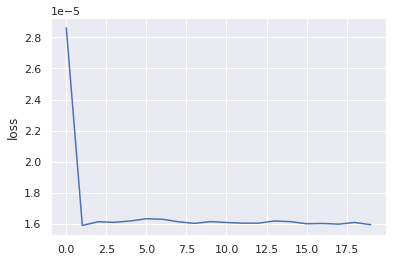

In [169]:
sns.set()
df_history = pd.DataFrame(history.history)
sns.lineplot(x = df_history.index, y = df_history.loss)

In [170]:
labels_pred = model.predict(split_features_test[0])
#np.corrcoef(labels_pred, labels_test)[0, 1]
print(split_labels_test[0][0])
print(len(labels_pred.flatten()), len(split_labels_test[0].flatten()))

0.0007242685201364207
1441 1441


In [171]:
np.corrcoef(labels_pred.flatten(), split_labels_test[0].flatten())[0, 1]

0.03782580600725657